In [58]:
import gym

In [59]:
env = gym.make('CartPole-v1')

In [60]:
env.seed(42)
obs = env.reset()

In [61]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [62]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

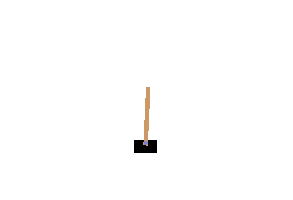

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_env(img, figsize=(5,4)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis("off")
    
plot_env(img)
plt.show()

In [64]:
env.action_space

Discrete(2)

In [65]:
action = 1
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

In [66]:
print(reward, obs)

1.0 [-0.01261699  0.19292789  0.04204097 -0.28092127]


In [67]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [68]:
totals = []

for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
        totals.append(episode_rewards)

In [69]:
import numpy as np
np.mean(totals), np.std(totals), np.max(totals), np.min(totals)

(21.80237931373513, 13.304311252666812, 67.0, 1.0)

In [70]:
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline


frames = []

for step in range(200):
    img = env.render('rgb_array')
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    if done:
        break
        
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

plot_animation(frames)
    

/Users/nickmatthew/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [14]:
import tensorflow as tf
n_inputs = 4

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=5, activation='elu', input_shape=[n_inputs]),
    tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

In [15]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make('CartPole-v1')
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode='rgb_array'))
        left_proba = model.predict(obs.reshape(1,-1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [16]:
frames = render_policy_net(model)
plot_animation(frames)

In [17]:
from tensorflow import keras
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iteration: 4999, Loss: 0.136

In [18]:
frames = render_policy_net(model)
plot_animation(frames)

# Policy Gradients

In [19]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [20]:

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [21]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [22]:
discount_rewards([10, 0, -50], discount_rate=.8)

array([-22, -40, -50])

In [23]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [24]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = .95

optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [26]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iteration: 149, mean rewards: 180.6

In [27]:
frames = render_policy_net(model)
plot_animation(frames)

In [28]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [29]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [30]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown

In [31]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [32]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

In [33]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [34]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [35]:
np.random.seed(42)

Q_values = np.full((3,3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0
    
alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.9 # discount factor
state = 0 # initial state
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at next step
    alpha = alpha0 / (1 + iteration*decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state
    
history2 = np.array(history2)

In [36]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [37]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

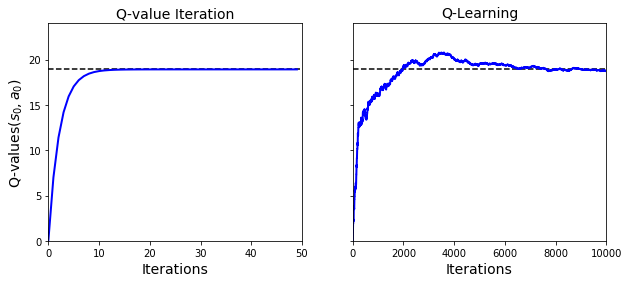

In [38]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
axes[0].set_ylabel("Q-values$(s_0, a_0)$", fontsize=14)
axes[0].set_title('Q-value Iteration', fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:,0,0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    

# Deep Q-Network

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make('CartPole-v1')
input_shape = env.observation_space.shape
n_outputs = env.action_space.n

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=32, activation=tf.nn.elu, input_shape=input_shape),
    tf.keras.layers.Dense(units=32, activation=tf.nn.elu),
    tf.keras.layers.Dense(n_outputs)
])

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [40]:
from collections import deque 

replay_memory = deque(maxlen=2000)

In [41]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [42]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [43]:
batch_size = 32
discount_rate = .95
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +(1-dones)*discount_rate*max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values*mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [44]:
env.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

rewards = []
best_score = 0

In [45]:
for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1-episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print('\rEpisode: {}, Steps: {}, eps: {:.3f}'.format(episode, step+1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    
model.set_weights(best_weights)

Episode: 51, Steps: 11, eps: 0.898WARNING:tensorflow:Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 599, Steps: 19, eps: 0.0108

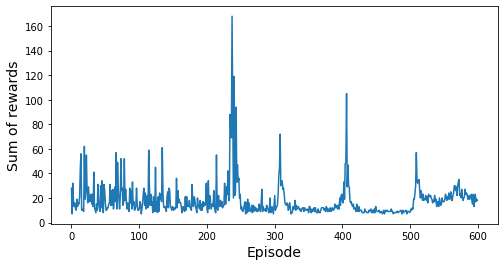

In [46]:
plt.figure(figsize=(8,4))
plt.xlabel('Episode', fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.plot(range(600), rewards)
plt.show()

In [47]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

# Double DQN

In [57]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=32, activation=tf.nn.elu, input_shape=[4]),
    tf.keras.layers.Dense(units=32, activation=tf.nn.elu),
    tf.keras.layers.Dense(units=n_outputs)
])

target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [58]:
batch_size = 32
discount_rate = .95
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss_fn = tf.keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states)*next_mask).sum(axis=1)
    target_Q_values = (rewards+(1-dones)*discount_rate*next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values*mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [59]:
replay_memory = deque(maxlen=2000)

In [60]:
env.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1-episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print('\rEpisode: {}, Steps: {}, eps: {:.3f}'.format(episode, step+1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 50 == 0:
        target.set_weights(model.get_weights())
        
model.set_weights(best_weights)

Episode: 51, Steps: 11, eps: 0.898WARNING:tensorflow:Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 599, Steps: 49, eps: 0.0100

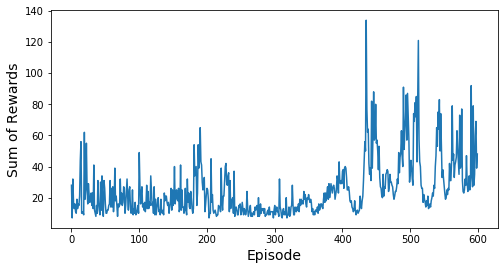

In [61]:
plt.figure(figsize=(8,4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of Rewards", fontsize=14)
plt.show()

# Dueling DQN

In [63]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = tf.keras.backend
input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation=tf.nn.elu)(input_states)
hidden2 = tf.keras.layers.Dense(32, activation=tf.nn.elu)(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = tf.keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [64]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [62]:
replay_memory = deque(maxlen=2000)

In [65]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 51, Steps: 15, eps: 0.898WARNING:tensorflow:Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 599, Steps: 74, eps: 0.0100

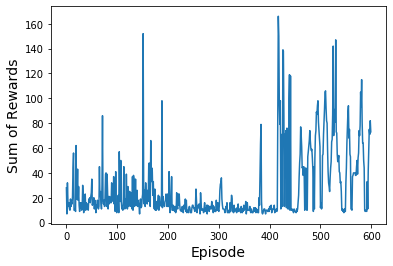

In [66]:
plt.plot(rewards)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Sum of Rewards', fontsize=14)
plt.show()

In [67]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

In [68]:
env.close()

# TF-Agents

In [1]:
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
tf.__version__

'2.3.1'

In [3]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [4]:
env.gym

In [5]:
env.seed(42)
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [6]:
action = np.array(1, dtype=np.int32)
env.step(action) # Fire

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

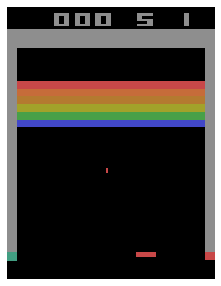

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


img = env.render(mode="rgb_array")
plt.figure(figsize=(4, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
env.current_time_step()

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [9]:
env.observation_spec()

BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)

In [12]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [13]:
repeating_env.unwrapped


In [10]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))


ActionClipWrapper           Wraps an environment and clips actions to spec before applying.
ActionDiscretizeWrapper     Wraps an environment with continuous actions and discretizes them.
ActionOffsetWrapper         Offsets actions to be zero-based.
ActionRepeat                Repeates actions over n-steps while acummulating the received reward.
FlattenObservationsWrapper  Wraps an environment and flattens nested multi-dimensional observations.
GoalReplayEnvWrapper        Adds a goal to the observation, used for HER (Hindsight Experience Replay).
HistoryWrapper              Adds observation and action history to the environment's observations.
ObservationFilterWrapper    Filters observations based on an array of indexes.
OneHotActionWrapper         Converts discrete action to one_hot format.
PerformanceProfiler         End episodes after specified number of steps.
PyEnvironmentBaseWrapper    PyEnvironment wrapper forwards calls to the given environment.
RunStats                    Wrapp

In [14]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load("Breakout-v4", gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
                                      env_wrappers=[partial(ActionRepeat, times=4)])

In [16]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(environment_name, max_episode_steps=max_episode_steps, 
                      gym_env_wrappers=[AtariPreprocessing, FrameStack4])

In [17]:
env

In [21]:
env.seed(42)
env.reset()
time_step = env.step(np.array([1]))
for _ in range(4):
    time_step = env.step(np.array([3]))

In [22]:
def plot_observation(obs):
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis('off')

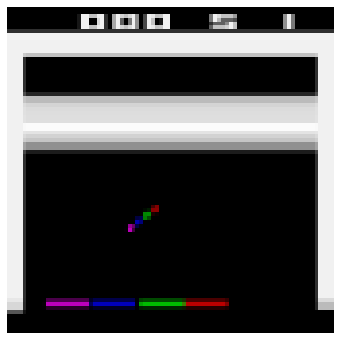

In [23]:
plt.figure(figsize=(6,6))
plot_observation(time_step.observation)
plt.show()

In [24]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

In [25]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

In [29]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

In [30]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
data_spec=agent.collect_data_spec,
batch_size=tf_env.batch_size,
max_length=1000000)

replay_buffer_observer = replay_buffer.add_batch

In [31]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [32]:
train_metrics[0].result()

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [50]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [35]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
tf_env,
agent.collect_policy,
observers=[replay_buffer_observer] + train_metrics,
num_steps=update_period)

In [37]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [38]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
init_driver = DynamicStepDriver(
tf_env,
initial_collect_policy,
observers=[replay_buffer.add_batch, ShowProgress(20000)],
num_steps=20000)
final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
20000/20000

In [39]:
tf.random.set_seed(888)

trajectories, buffer_info = replay_buffer.get_next(sample_batch_size=2, num_steps=3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [40]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [41]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [42]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [43]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

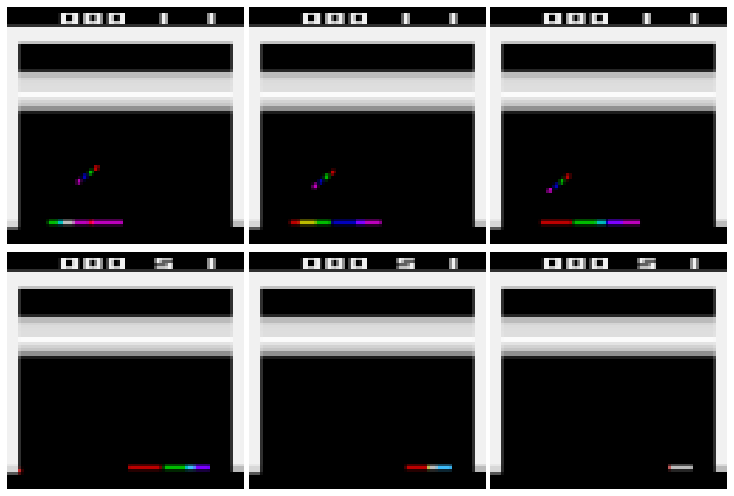

In [44]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row*3+col+1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0,
                           wspace=0.02)
plt.show()

In [45]:
dataset=replay_buffer.as_dataset(
sample_batch_size=64,
num_steps=2,
num_parallel_calls=3).prefetch(3)

In [47]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [51]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [52]:
train_agent(n_iterations=10000)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 8
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


998 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 4008
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 182.89999389648438


1998 loss:0.00760

INFO:absl: 
		 NumberOfEpisodes = 45
		 EnvironmentSteps = 8008
		 AverageReturn = 1.899999976158142
		 AverageEpisodeLength = 210.10000610351562


2999 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 67
		 EnvironmentSteps = 12008
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 188.60000610351562


3998 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 88
		 EnvironmentSteps = 16008
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 188.60000610351562


4998 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 112
		 EnvironmentSteps = 20008
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 171.3000030517578


5999 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 132
		 EnvironmentSteps = 24008
		 AverageReturn = 1.0
		 AverageEpisodeLength = 175.60000610351562


6999 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 155
		 EnvironmentSteps = 28008
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 174.6999969482422


7999 loss:0.00762

INFO:absl: 
		 NumberOfEpisodes = 176
		 EnvironmentSteps = 32008
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 188.1999969482422


8998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 198
		 EnvironmentSteps = 36008
		 AverageReturn = 1.0
		 AverageEpisodeLength = 172.1999969482422


9999 loss:0.00014

In [71]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(np.array([1]))
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

1000/1000

In [74]:
import PIL
import os

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

FileNotFoundError: [Errno 2] No such file or directory: 'images/rl/breakout.gif'

In [72]:
%%html
<img src="images/rl/breakout.gif" />